In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn_som.som import SOM
from sklearn.linear_model import Perceptron
from sklearn.svm import SVR
from sklearn_lvq import GlvqModel


from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

The Hour column in the dataset is coded, so the `HOURS` dictionary below translates the codes into the actual time during the day. Similarly, we've created that same logic for the weekdays.

In [5]:
data=pd.read_csv("Traffic_behavior_Brazil.csv")
data.head()

,Hour (Coded);Immobilized bus;Broken Truck;Vehicle excess;Accident victim;Running over;Fire vehicles;Occurrence involving freight;Incident involving dangerous freight;Lack of electricity;Fire;Point of flooding;Manifestations;Defect in the network of trolleybuses;Tree on the road;Semaphore off;Intermittent Semaphore;Slowness in traffic (%)
1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;4,1.0
2;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;6,6.0
3;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;8,7.0
4;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;9,2.0
5;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;11,1.0


In [6]:
HOURS = {7:00, 7:30, 8:00, 8:30, 9:00, 9:30, 10:00, 10:30, 11:00, 11:30, 12:00, 12:30, 13:00, 13:30, 14:00, 14:30, 15:00, 15:30, 16:00, 16:30, 17:00, 17:30, 18:00, 18:30, 19:00, 19:30, 20:00} # reference from dataset folder
DATA_PATH = "Traffic_behavior_Brazil.csv"
TARGET_VAR = "Slowness in traffic (%)"
MONDAY  = 26
TUESDAY = 53
WEDNESDAY = 80
THURSDAY = 107
FRIDAY = 134
DAYS_TO_CODE = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5}

# <div id="a">1. Data Overview</div>


In [7]:
def load_data(path:str=DATA_PATH, sep:str=";"):
    try:
        df = pd.read_csv(path, sep=sep)
        print("Data loaded with success")
        return df
    except FileNotFoundError:
        print("Check your data directory! Nothing there yet...")
        return False

In [8]:
df = load_data()
df.head()

Data loaded with success


,Hour (Coded),Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore,Slowness in traffic (%)
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"4,1"
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"6,6"
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"8,7"
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"9,2"
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"11,1"


In [9]:
df.isnull().sum()

Hour (Coded)                             0
Immobilized bus                          0
Broken Truck                             0
Vehicle excess                           0
Accident victim                          0
Running over                             0
Fire vehicles                            0
Occurrence involving freight             0
Incident involving dangerous freight     0
Lack of electricity                      0
Fire                                     0
Point of flooding                        0
Manifestations                           0
Defect in the network of trolleybuses    0
Tree on the road                         0
Semaphore off                            0
Intermittent Semaphore                   0
Slowness in traffic (%)                  0
dtype: int64

Luckily, there are no null values.

In [10]:
print(f"Dataframe shape: {df.shape}\n")
df.info()

Dataframe shape: (135, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Hour (Coded)                           135 non-null    int64 
 1   Immobilized bus                        135 non-null    int64 
 2   Broken Truck                           135 non-null    int64 
 3   Vehicle excess                         135 non-null    int64 
 4   Accident victim                        135 non-null    int64 
 5   Running over                           135 non-null    int64 
 6   Fire vehicles                          135 non-null    int64 
 7   Occurrence involving freight           135 non-null    int64 
 8   Incident involving dangerous freight   135 non-null    int64 
 9   Lack of electricity                    135 non-null    int64 
 10  Fire                                   135 non-null    int

In [11]:
df.describe()

,Hour (Coded),Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore
count,135.00000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,14.00000,0.340741,0.874074,0.029630,0.422222,0.118519,0.007407,0.007407,0.007407,0.118519,0.007407,0.118519,0.051852,0.229630,0.044444,0.125926,0.014815
std,7.81789,0.659749,1.102437,0.170195,0.696116,0.346665,0.086066,0.086066,0.086066,0.504485,0.086066,0.712907,0.222554,0.818998,0.206848,0.464077,0.121261
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.00000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,27.00000,4.000000,5.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,7.000000,1.000000,8.000000,1.000000,4.000000,1.000000


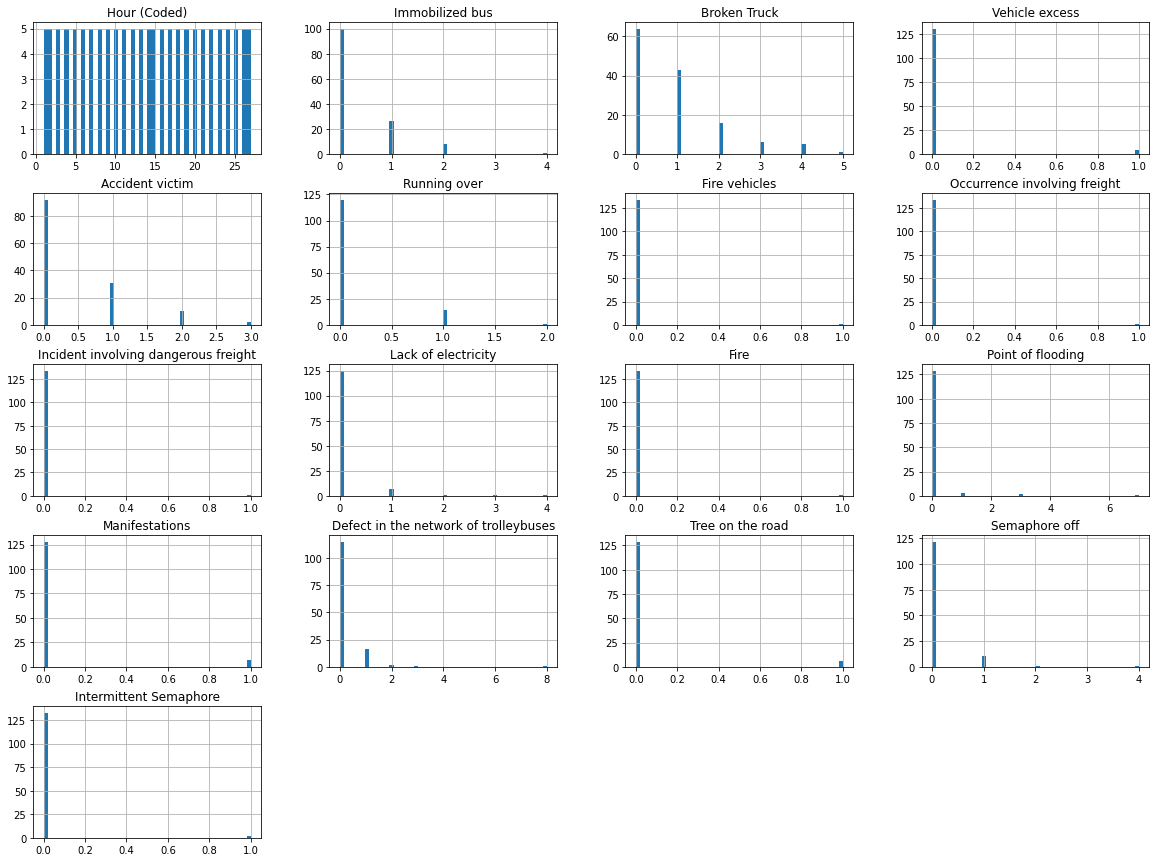

In [12]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

# <div id="b">2. Data Manipulation</div>

In [13]:
def transform_target(df, target_var=TARGET_VAR, to=float):
    df[target_var] = df[target_var].str.replace(',', '.').astype(to)
transform_target(df)

Here we make available a function so that you can create the day column as weekday nomenclature or as ordinal numbers:

In [14]:

def transform_days(df, create_column=False, to_numerical=False):
    
    if create_column:
        df['Day'] = '0'

    position=-1
    if to_numerical is False:
        for idx in df.index:
            if idx <= MONDAY:
                df.iloc[idx, position] = 'Monday'
            elif idx <= TUESDAY:
                df.iloc[idx, position] = 'Tuesday'
            elif idx <= WEDNESDAY:
                df.iloc[idx, position] = 'Wednesday'
            elif idx <= THURSDAY:
                df.iloc[idx, position] = 'Thursday'
            elif idx <= FRIDAY:
                df.iloc[idx, position] = 'Friday'
    else:
        df_values = df["Day"].unique()
        for key, value in DAYS_TO_CODE.items():
            assert key in df_values, "First transform your data into weekday by setting to_numerical=False, then apply the numerical transformation"
            df.loc[(df.Day == key), 'Day'] = value
        df['Day'] = df['Day'].astype(int)
        
transform_days(df, create_column=True)

In [15]:
# Create code to hour dict
def set_hours_dict(df, hours:dict =HOURS)-> dict:
    hours_arr = []

    for hour, minute in hours.items():
      s1 = str(hour) + ':' + '00'
      s2 = str(hour) + ':' + str(minute)
      if hour != 20:
        hours_arr.append(s1)
        hours_arr.append(s2)
      else:
        hours_arr.append(s1)

    code_to_hour = {}
    for code, hour in zip(df['Hour (Coded)'], hours_arr):
      code_to_hour[code] = hour

    return code_to_hour

code_to_hour = set_hours_dict(df)

def code_hour(code):
  return code_to_hour[code]

# <div id="c">3. Exploratory Data Analysis</div>


### Correlation matrices

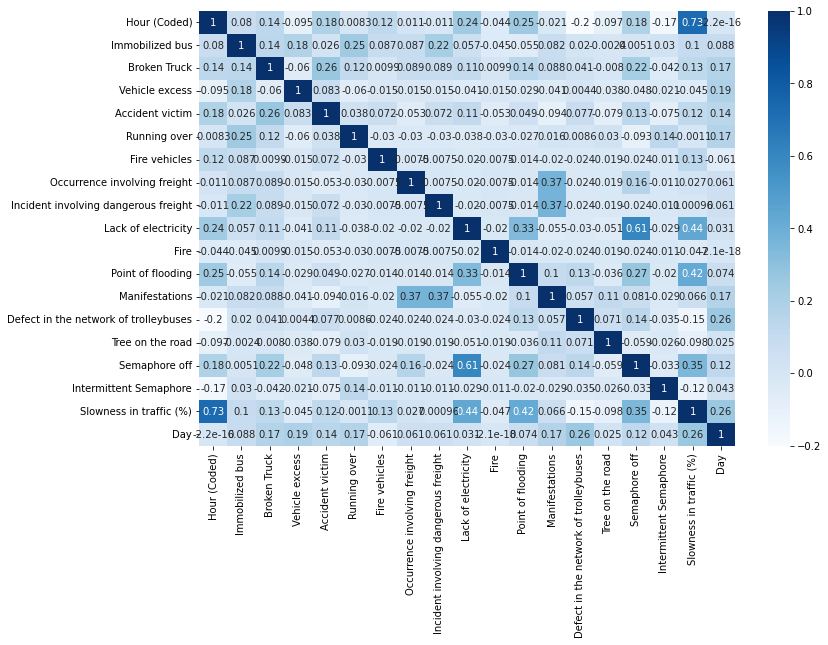

In [12]:
transform_days(df, to_numerical=True)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.show()

In [13]:
corr_matrix = df.corr()
corr_matrix['Slowness in traffic (%)'].sort_values(ascending=False)

Slowness in traffic (%)                  1.000000
Hour (Coded)                             0.729962
Lack of electricity                      0.436569
Point of flooding                        0.420016
Semaphore off                            0.347242
Day                                      0.261948
Fire vehicles                            0.134103
Broken Truck                             0.131998
Accident victim                          0.121730
Immobilized bus                          0.101143
Manifestations                           0.066377
Occurrence involving freight             0.026791
Incident involving dangerous freight     0.000957
Running over                            -0.001133
Vehicle excess                          -0.045297
Fire                                    -0.046737
Tree on the road                        -0.098489
Intermittent Semaphore                  -0.119942
Defect in the network of trolleybuses   -0.147035
Name: Slowness in traffic (%), dtype: float64

As expected, the time of the day is the variable that has the largest impact on the Slowness in Traffic among the other features. Features such as Lack of Electricity and Flooding have a considerable effect on the target variable as well.

array([[<AxesSubplot:xlabel='Slowness in traffic (%)', ylabel='Slowness in traffic (%)'>,
        <AxesSubplot:xlabel='Hour (Coded)', ylabel='Slowness in traffic (%)'>],
       [<AxesSubplot:xlabel='Slowness in traffic (%)', ylabel='Hour (Coded)'>,
        <AxesSubplot:xlabel='Hour (Coded)', ylabel='Hour (Coded)'>]],
      dtype=object)

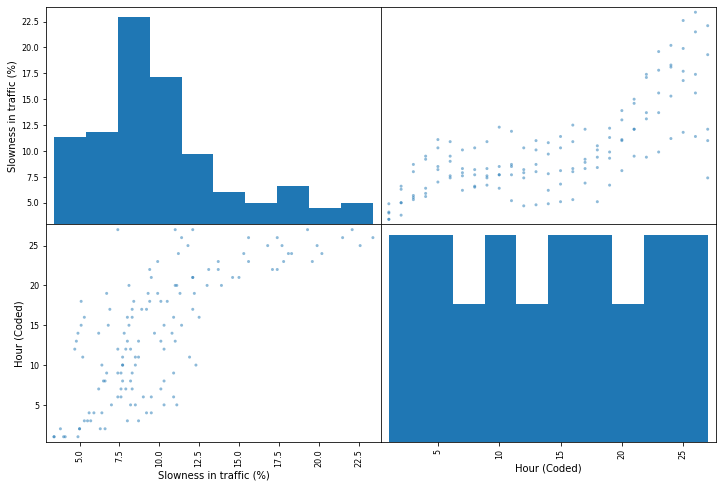

In [14]:
attributes = ["Slowness in traffic (%)", "Hour (Coded)"]
scatter_matrix(df[attributes], figsize=(12, 8))

### Plot overtime

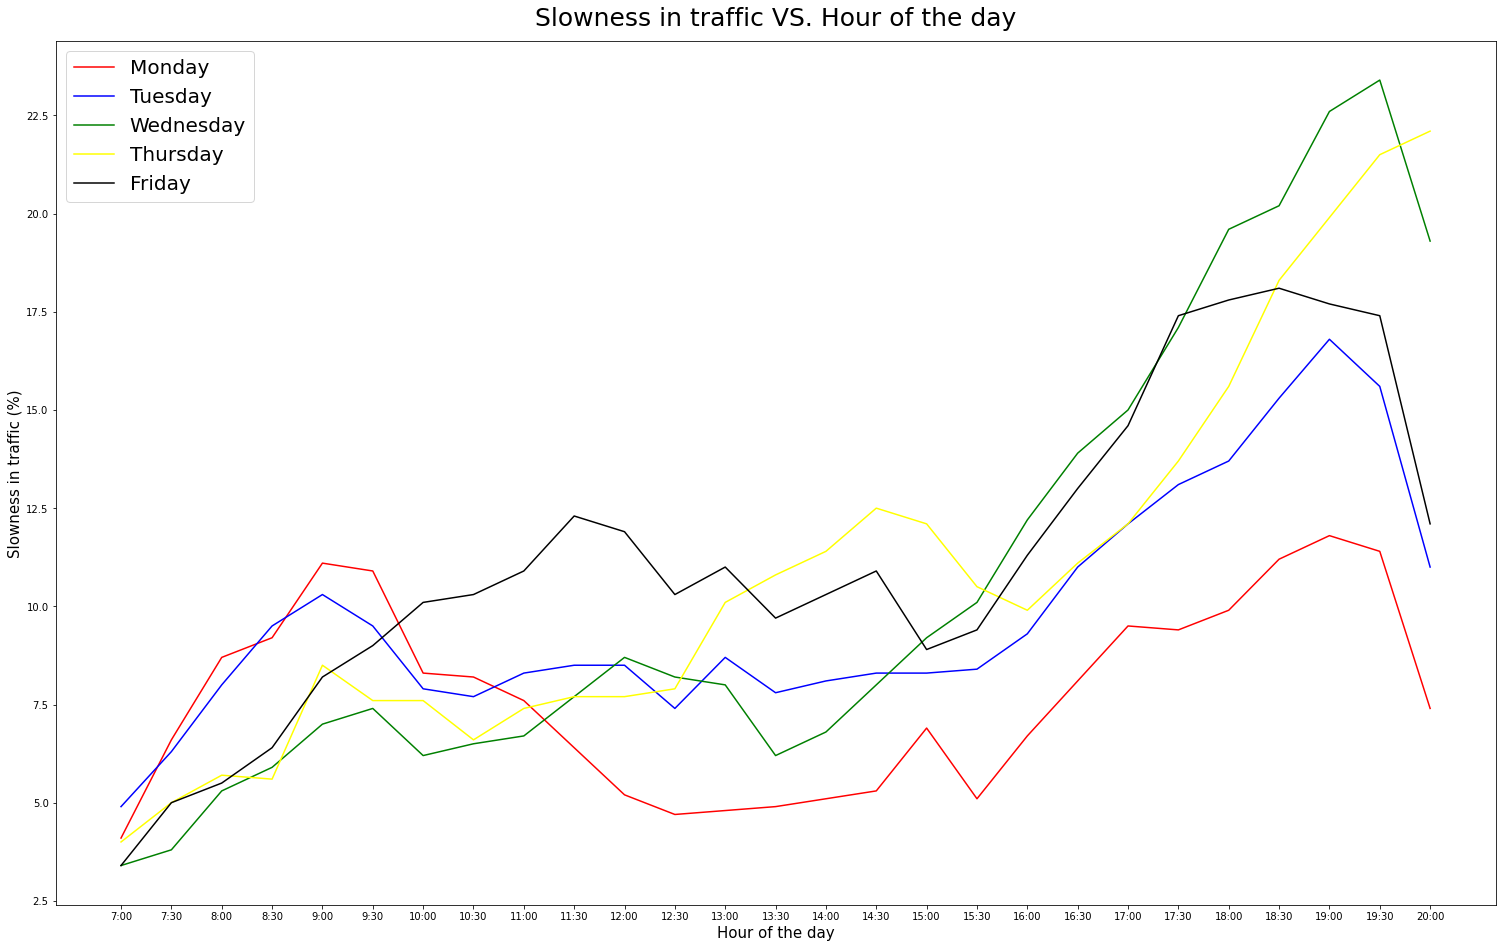

In [16]:
def slowness_over_time(df, coded_hours=False):
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_axes([0, 0, 1, 1])

    colors = {'Monday': 'r', 'Tuesday': 'b', 'Wednesday': 'g', 'Thursday': 'yellow', 'Friday':'black'}
    transform_days(df)
    for e in df['Day'].unique():
        subset = df[df['Day'] == e]
        ax.plot(subset['Hour (Coded)'], subset['Slowness in traffic (%)'],color=colors[e])

    ax.set_title('Slowness in traffic VS. Hour of the day', fontsize=25, pad=15)
    ax.set_xlabel('Hour of the day', fontsize=15)
    ax.set_ylabel('Slowness in traffic (%)', fontsize=15)
    
    if coded_hours is False:
        ax.set_xticks(range(1, 28))
        ax.set_xticklabels(map(code_hour, subset['Hour (Coded)'].unique()))

    ax.legend(colors, fontsize=20)

    plt.show()
slowness_over_time(df)
transform_days(df, to_numerical=True)

Traffic peaks in the late afternoon and early evening exceed those in the morning; Wednesday has the highest peak in traffic while Monday afternoon is the period with the lowest traffic levels.

## Boxplot

We decided not to remove the outliers, since the dataset is small and outliers in this situation represents an important characteristc of traffic peaks, also known as the "rush hour".

/var/folders/6g/4d8bjqz5613fn0rclrn4nx980000gn/T/ipykernel_16206/664070139.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(number_of_rows + 1,number_of_columns,i+1)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/var/folders/6g/4d8bjqz5613fn0rclrn4nx980000gn/T/ipykernel_16206/664070139.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecate

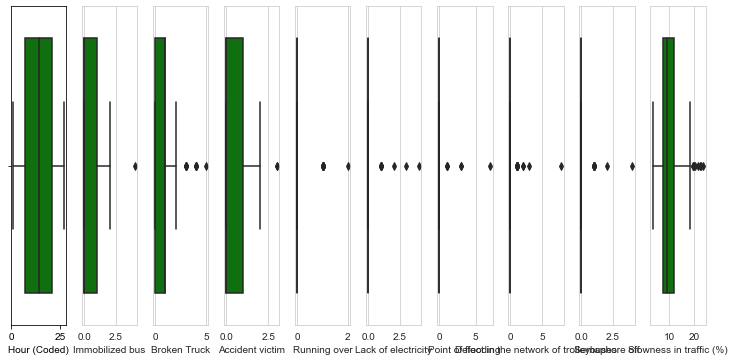

In [17]:
num_cols = df.nunique()[df.nunique() > 2].keys() # Discriminate non-categorical data
num_cols = num_cols.drop('Day')

l = num_cols.values
number_of_columns=len(num_cols.values)
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))

for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='green',orient='v')
    plt.tight_layout()

In [18]:
df.groupby('Day')['Slowness in traffic (%)'].mean()

Day
1     7.722222
2     9.788889
3    10.681481
4    10.848148
5    11.218519
Name: Slowness in traffic (%), dtype: float64

# <div id="d">4. Data Preprocessing</div>


In [19]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Hour (Coded)"])

# Verifying stratified distribution
print("Train set class proportions:\n")
print(train_set["Hour (Coded)"].value_counts() / len(train_set))
print("\nFull set:")
print(df["Hour (Coded)"].value_counts() / len(df))

Train set class proportions:

20    0.037037
16    0.037037
9     0.037037
1     0.037037
18    0.037037
2     0.037037
12    0.037037
23    0.037037
25    0.037037
27    0.037037
3     0.037037
26    0.037037
21    0.037037
13    0.037037
10    0.037037
8     0.037037
19    0.037037
22    0.037037
24    0.037037
5     0.037037
15    0.037037
7     0.037037
6     0.037037
4     0.037037
14    0.037037
17    0.037037
11    0.037037
Name: Hour (Coded), dtype: float64

Full set:
1     0.037037
15    0.037037
26    0.037037
25    0.037037
24    0.037037
23    0.037037
22    0.037037
21    0.037037
20    0.037037
19    0.037037
18    0.037037
17    0.037037
16    0.037037
14    0.037037
2     0.037037
13    0.037037
12    0.037037
11    0.037037
10    0.037037
9     0.037037
8     0.037037
7     0.037037
6     0.037037
5     0.037037
4     0.037037
3     0.037037
27    0.037037
Name: Hour (Coded), dtype: float64


In [20]:
X_train = train_set.drop("Slowness in traffic (%)", axis=1)
y_train = train_set["Slowness in traffic (%)"].copy()

Here we're discriminating the numerical values set by removing the categorical features (variable *Day* and variables with only 2 unique values); this is necessary for future feature scaling.

In [21]:
x_num_cols = X_train.nunique()[X_train.nunique() > 2].keys()
x_num_cols = x_num_cols.drop('Day')
numerical_data = list(x_num_cols)

### Transformation Pipelines

We apply the standard scaling on the numerical features through the scikit-learn classes Pipeline and Column Transformer. 

In [22]:
num_pipeline = Pipeline([('std_scaler', StandardScaler())])
full_pipeline = ColumnTransformer([("num", num_pipeline, numerical_data)], remainder='passthrough')

In [23]:
X_train_prepared = full_pipeline.fit_transform(X_train)

# <div id="e">5. Model Building</div>
We selected a few machine learning models based on the book (*Hands On Machine Learning*) notebook and trained them using 10 fold cross-validation. 

In [24]:
p_reg = Perceptron(random_state=42)
#p_reg.fit(X_train, y_train, **fit_params)
scores = cross_val_score(p_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
p_rmse_scores = np.sqrt(-scores)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 677, in _fit
    self._partial_fit(
  File "/opt/anaconda3/lib/python3.

In [25]:
svm_reg = SVR(kernel="linear")
svr_scores = cross_val_score(svm_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)

In [26]:
gl_reg = GlvqModel()
#gl_reg.fit(X_train,y_train)
gl_scores = cross_val_score(gl_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
gl_rmse_scores = np.sqrt(-gl_scores)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn_lvq/lvq.py", line 100, in fit
    x, y, random_state = self._validate_train_parms(x, y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn_lvq/glvq.py", line 184, in _validate_train_parms
    ret = super(GlvqModel, self)._validate_train_parms(t

# <div id="f">6. Model Performances</div>

We preselected the model with the best performance/lowest mean score (Random Forest) and ran a GridSearch in order to determine the best hyperparameters for optimization purposes.

In [28]:
data = {
    "Model":["perceptron", "SVR", "LVQ"],
    "Mean Score": [p_rmse_scores.mean(), svr_rmse_scores.mean(), gl_rmse_scores.mean()],
    "Standard Deviation": [p_rmse_scores.std(), svr_rmse_scores.std(), gl_rmse_scores.std()]
}
scores_df = pd.DataFrame(data)
scores_df

,Model,Mean Score,Standard Deviation
0,perceptron,NaN,NaN
1,SVR,2.773959,0.633812
2,LVQ,NaN,NaN


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [10, 12, 14, 16, 18]},
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False],
                          'max_features': [10, 12, 14, 16, 18],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [30]:
best_grid_model = grid_search.best_estimator_
print("Best model paramateres:", grid_search.best_params_)

Best model paramateres: {'max_features': 18, 'n_estimators': 10}


Here you can find what the model defines as the most important features in predicting the Slowness in Traffic, after learning with the train set.

In [31]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, list(X_train)), reverse=True)

[(0.7049681438130666, 'Hour (Coded)'),
 (0.21655516972861602, 'Day'),
 (0.023383152191741818, 'Accident victim'),
 (0.01491347315378658, 'Broken Truck'),
 (0.01116047409625949, 'Immobilized bus'),
 (0.010398344565016487, 'Vehicle excess'),
 (0.008199891549132858, 'Running over'),
 (0.004409175831771046, 'Lack of electricity'),
 (0.0032677401864802495, 'Occurrence involving freight'),
 (0.0014072294333901713, 'Fire vehicles'),
 (0.0006771265731183848, 'Intermittent Semaphore'),
 (0.000362632378627253, 'Incident involving dangerous freight'),
 (0.00020405920703562303, 'Tree on the road'),
 (5.979287661202195e-05, 'Semaphore off'),
 (2.9905229442244178e-05, 'Defect in the network of trolleybuses'),
 (3.6891859032174338e-06, 'Manifestations'),
 (0.0, 'Point of flooding'),
 (0.0, 'Fire')]

## Final Results

Lastly, we applied the model on the test set and calculated the final score!


In [32]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("Slowness in traffic (%)", axis=1)
y_test = test_set["Slowness in traffic (%)"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [33]:
final_rmse

1.957014922632786

In [34]:
# Here are a few examples...
predictions = final_predictions[:10]
actual_results = y_test[:10]

for p, a in zip(predictions, actual_results):
    print("Predicted: {:.2f} - Expected: {}".format(p, a))

Predicted: 9.66 - Expected: 11.0
Predicted: 6.88 - Expected: 5.1
Predicted: 11.13 - Expected: 10.8
Predicted: 17.03 - Expected: 13.7
Predicted: 7.68 - Expected: 6.7
Predicted: 19.57 - Expected: 17.7
Predicted: 8.66 - Expected: 7.6
Predicted: 5.51 - Expected: 5.3
Predicted: 10.52 - Expected: 7.7
Predicted: 8.22 - Expected: 8.3
